<a href="https://colab.research.google.com/github/compi1234/pyspch/blob/master/test/spectrogram_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentations

In this demo we illustrate segmentations at the word, phoneme and character level

This notebook simultaneously demonstrates varies functionalities available within the **pyspch.spectrogram** module

- plotting of waveforms , spectrograms and segmentations
- computation of basic and mel spectrograms (wrappers around libosa)

Date: 26/07/2021   
Author: Dirk Van Compernolle

## First do all the imports


In [1]:
# GETTING STARTED: You may need to uncomment following OPTIONAL code blocks below to get started on your system
#
# Install 'pyspch' from github if you don't haven't done so yet
# !pip install git+https://github.com/compi1234/pyspch.git
#
# Uncomment the following block If you prefer/need to use the plotly backend (yields editable plots in a separate browser window)
import os
import plotly.io as pio
os.environ['PYSPCH_BACKEND'] = "plotly"
#pio.renderers.default = 'browser'

In [1]:
%matplotlib inline
import os,sys,io 
import scipy.signal

from urllib.request import urlopen
from IPython.display import display, Audio, HTML, clear_output
from ipywidgets import interact

import math,time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

import librosa as librosa
    
import pyspch.spectrogram as specg
import pyspch.audio as audio
import pyspch.utils as spch_utils

import pyspch.display as spchd
import pyspch.timit_file_tools as tio

## 1. Read in audio data and compute spectrograms

In [2]:
# Some audio examples to choose from in https://homes.esat.kuleuven.be/~spchlab/data
# timit/   si1027, sa1, sx313
# misc/    friendly, m1, f1, f2, ..  
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
name = 'misc/friendly'
#name = 'timit/si1027'
#
wavfname = os.path.join(dir,name+".wav")
wavdata, sr = audio.load(wavfname)
# get segmentations and convert TIMIT segmentations from sample indices to time, plus map from the TIMIT61 alphabet to CMU
if name.split('/')[0] == 'timit':
    dsegt = 1./16000.
    xlat = 'map61_cmu'
else:
    dsegt = 1.
    xlat = None
segwrd = tio.read_seg_file(dir+name+ ".wrd",dt=dsegt,fmt='float32')
segsyl = tio.read_seg_file(dir+name+ ".syl",dt=dsegt,fmt='float32')
seggra = tio.read_seg_file(dir+name+ ".gra",dt=dsegt,fmt='float32')
segphn = tio.read_seg_file(dir+name+ ".phn",dt=dsegt,fmt='float32',xlat=xlat)

# compute spectrograms 
shift=0.01
spgfreq = specg.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
(nparam,nfr)=spgfreq.shape
d_freq = sr/(2.*(nparam-1))
# if you prefer a mel filterbank
mel80 = specg.spg2mel(spgfreq,sample_rate=sr,n_mels=80)
mel24 = specg.spg2mel(spgfreq,sample_rate=sr,n_mels=24)
# or if you prefer mel cepstral coefficients
mfcc24_12=librosa.feature.mfcc(S=mel24,sr=sr,n_mfcc=12,dct_type=3)
mfcc80_24=librosa.feature.mfcc(S=mel80,sr=sr,n_mfcc=24,dct_type=3)

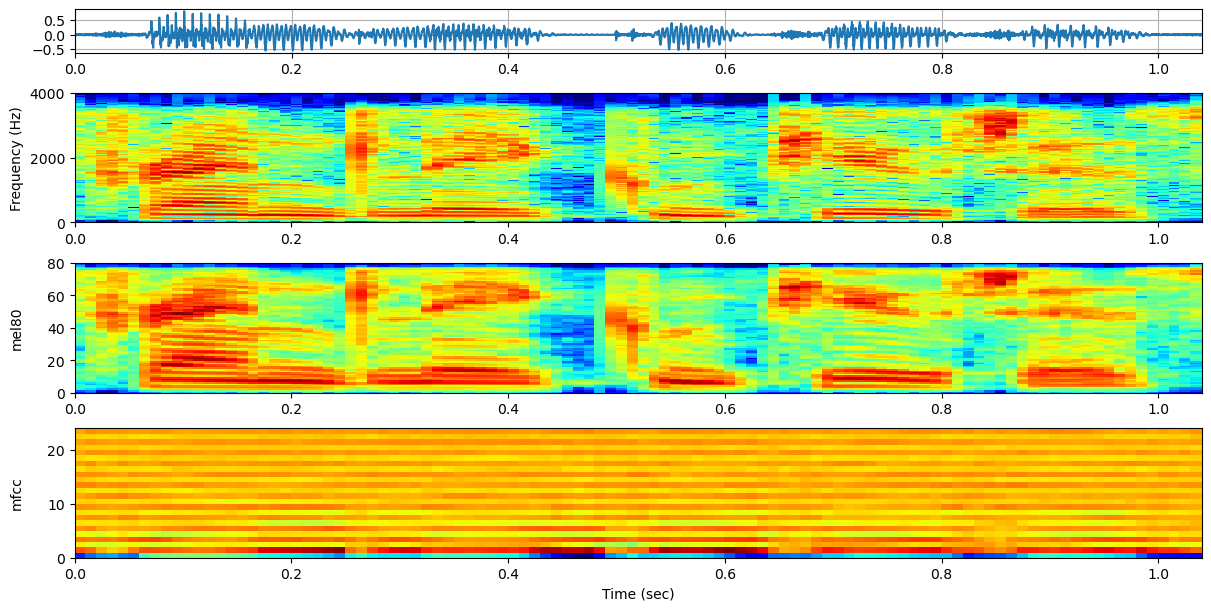

In [3]:
spchd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,img_ftrs=[mel80,mfcc80_24],sample_rate=sr,img_labels=['mel80','mfcc'])

## 2. Basic Waveform Plot or Spectrogram Plotting
- plot_waveform() plots multichannel waveforms
- plot_spg() plots a spectrogram and (optional) waveform 

In both cases it is possible to overlay segmentations on the plots

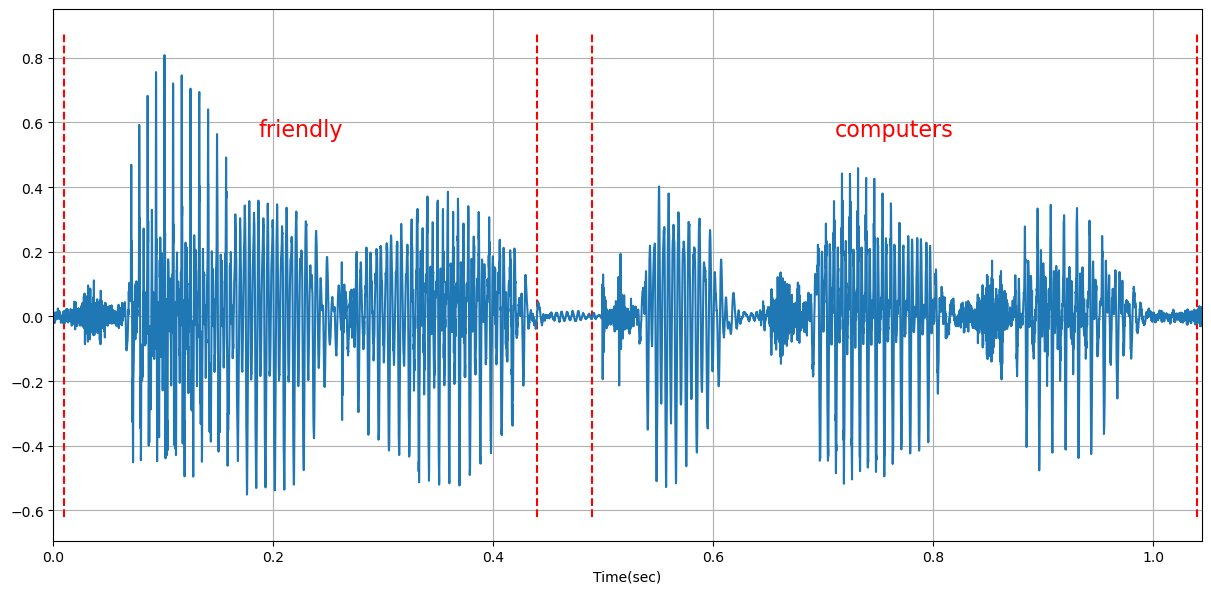

In [4]:
fig = spchd.PlotWaveform(wavdata,sample_rate=sr,seg=segwrd)
display(fig)
display(Audio(data=wavdata,rate=sr))

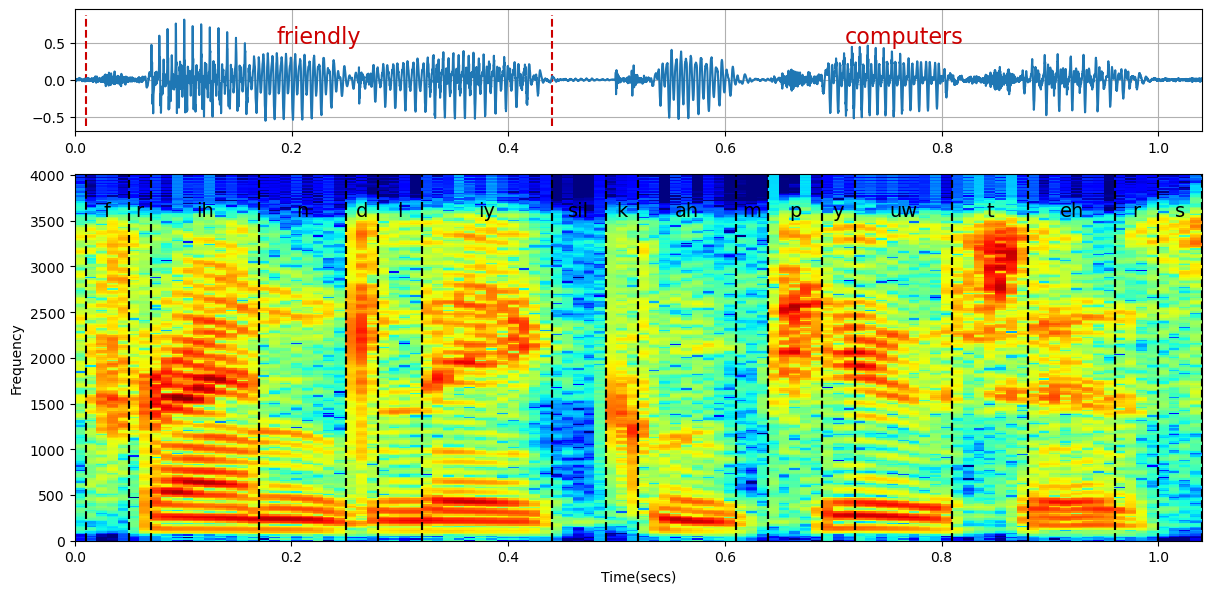

In [5]:
fig = spchd.PlotSpg(spgdata=spgfreq,wavdata=wavdata,segwav=segwrd,segspg=segphn,sample_rate=sr,dy=d_freq,frames=None,ylabel='Frequency')
display(fig)


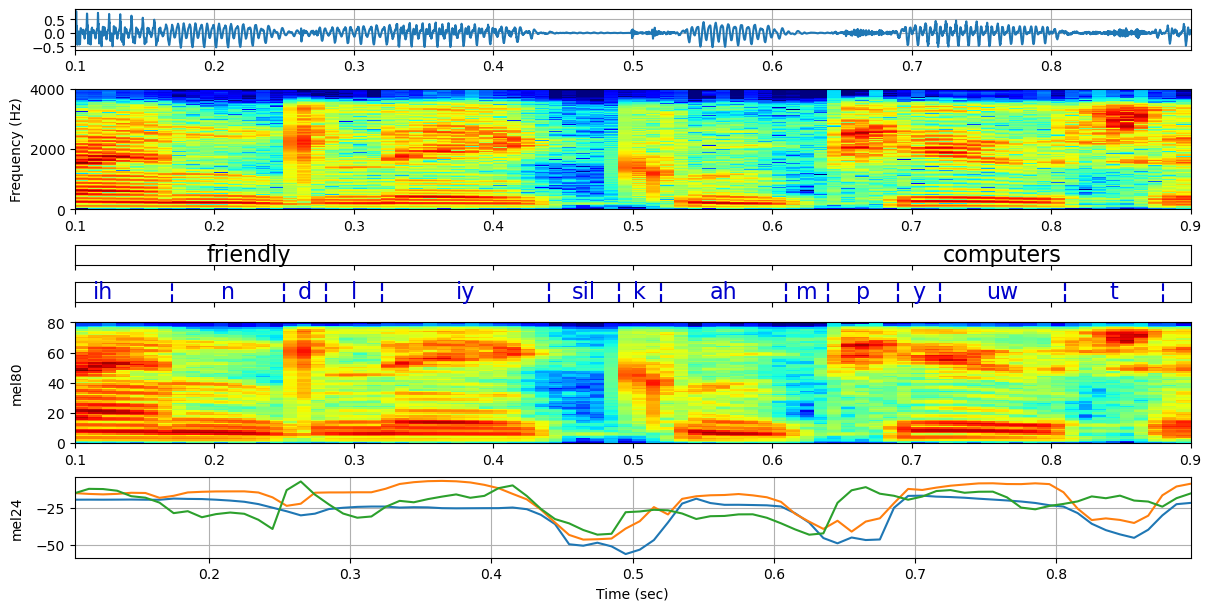

In [6]:
fig = spchd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,segdata=[segwrd,segphn],img_ftrs=[mel80], line_ftrs=[mel24[[0,3,18],:]],
              sample_rate=sr,frames=[10,90],img_labels=['mel80'],line_labels=['mel24'])
display(fig)

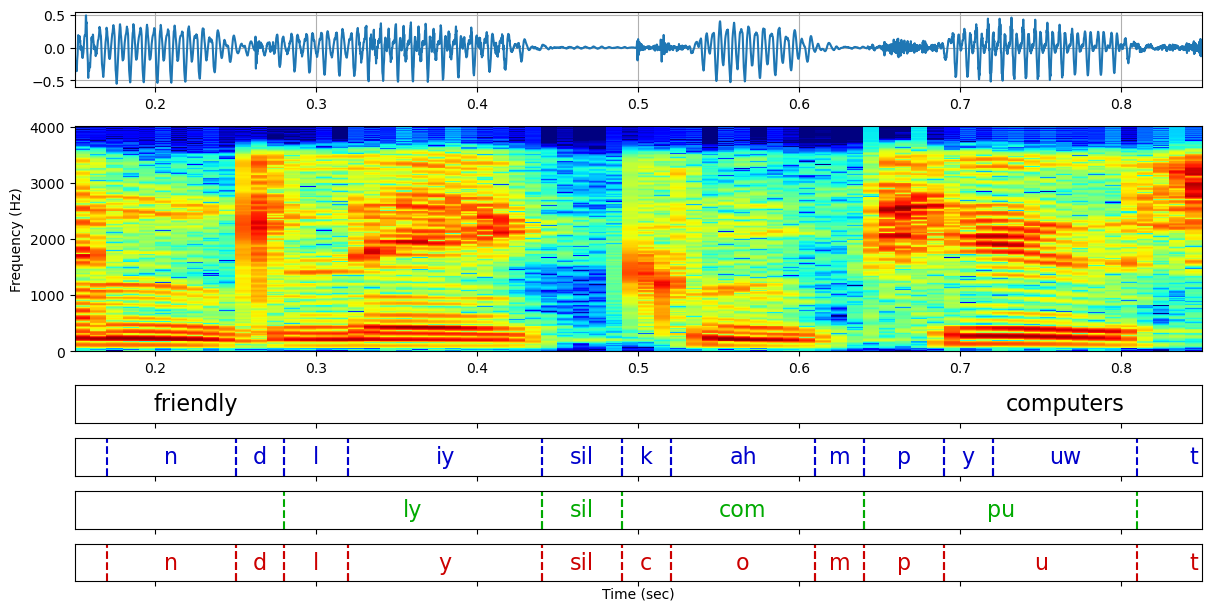

In [7]:
fig = spchd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,segdata=[segwrd,segphn,segsyl,seggra],   
              sample_rate=sr,frames=[15,85],dy=None)
display(fig)

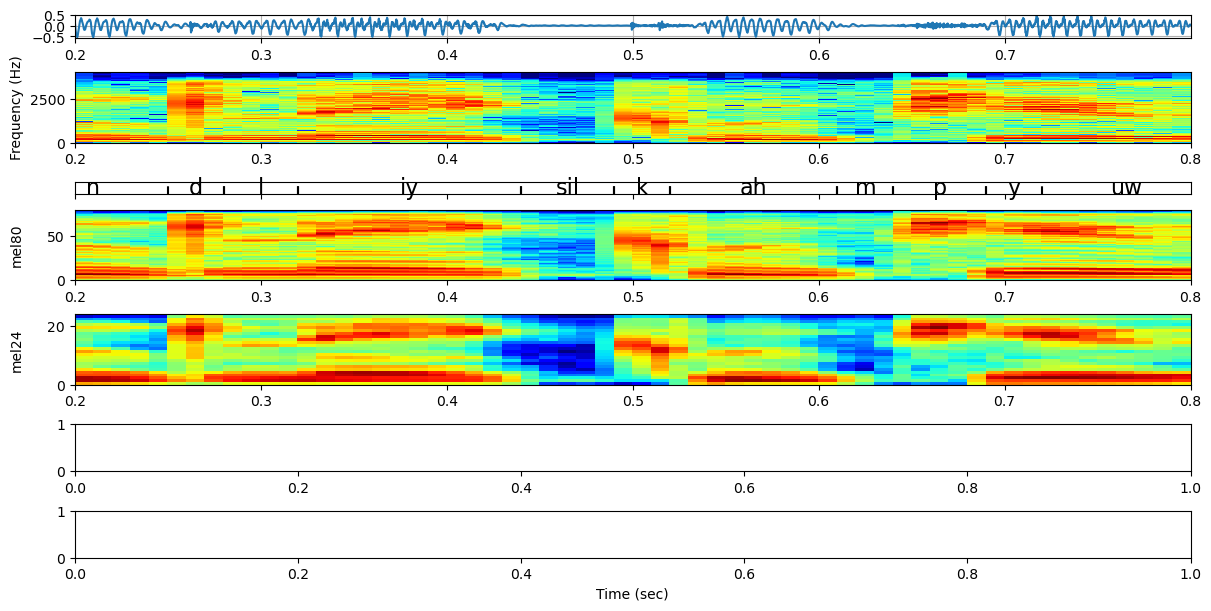

In [8]:
fig = spchd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,segdata=[segphn],img_ftrs=[mel80,mel24],
                  img_labels=['mel80','mel24'], line_ftrs=[None,None],sample_rate=sr,frames=[20,80])
#sns.lineplot(fig.axes[5],mel24)
display(fig)

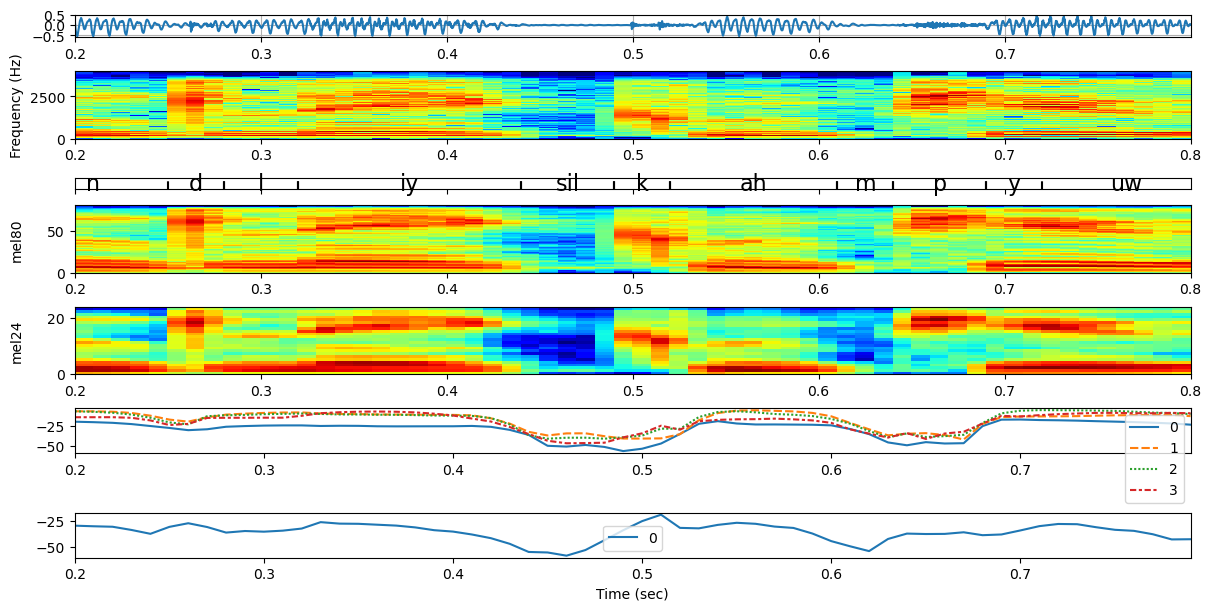

In [9]:
sns.lineplot(ax=fig.axes[5],data=pd.DataFrame(mel24[0:4,20:80].T,index=np.arange(20,80)*0.01),legend=True)
sns.lineplot(ax=fig.axes[6],data=pd.DataFrame(mel24[7,20:80].T,index=np.arange(20,80)*0.01),legend=True)
display(fig)

### -- WARNING: EXAMPLES BELOW ONLY WORK WITH THE **MATPLOLIB** BACKEND --

## Interactive Plot for highlighting shorter fragments

A small interactive app to display & play a small selection of the waveform

In [10]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive, interactive_output, Layout

def box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

class int_specg(widgets.VBox):
    def __init__(self,spgdata=None,wavdata=None,segdata=None,img_ftrs=None,line_ftrs=None,shift=0.01,sample_rate=16000):
        super().__init__()

        self.spgdata = spgdata
        self.segdata = segdata
        self.wavdata = wavdata
        self.line_ftrs = line_ftrs
        self.img_ftrs = img_ftrs
        self.sample_rate = sample_rate
        self.shift = shift
        
        (nparam,nfr)=spgdata.shape        
        self.nfr = nfr
        self.range = np.asarray([0, self.nfr])        
        self.nshift = int(self.shift*self.sample_rate)
        
        self.wg_range = widgets.IntRangeSlider(value=self.range.tolist(),min=0,max=self.nfr,
                            description='',continuous_update=True,readout=False, 
                            layout=Layout(width='100%',padding='5px 5px 5px 5px'))
        self.wg_range.observe(self.range_observe,'value')
        self.out = widgets.Output(layout=box_layout())
        self.audio = widgets.Output()
        self.wave = widgets.Output()
        self.UI = widgets.HBox([
            widgets.VBox( [  self.wg_range , self.wave],layout=Layout(width='60%') ),
            widgets.VBox([self.audio ],layout=Layout(align_items='center',justify_items='center',padding='20px 20px 20px 20px')) 
            ], layout=box_layout())
        with self.wave:
            display(spchd.PlotWaveform(self.wavdata,self.sample_rate,figsize=(6,1.5)))
        self.fig = spchd.PlotSpgFtrs(wavdata=self.wavdata,sample_rate=self.sample_rate,spgdata=self.spgdata,segdata=self.segdata,
                           img_ftrs=self.img_ftrs,line_ftrs=self.line_ftrs,frames=self.range)
        #self.fig = spchd.plot_spg(self.spg,None,self.wavdata,sample_rate=self.sample_rate,seg_wav=self.segs,frames=self.range)
        self.update()
        plt.close()
        self.children = [  self.out,  self.UI ]
        
    def update(self):
        self.fig = spchd.PlotSpgFtrs(wavdata=self.wavdata,sample_rate=self.sample_rate,spgdata=self.spgdata,segdata=self.segdata,
                           img_ftrs=self.img_ftrs,line_ftrs=self.line_ftrs,frames=self.range)
        #spchd.plot_spg(self.spg,fig=self.fig,wav=self.wavdata,dt=1./self.sample_rate, frames=self.range)        
        with self.wave:
            clear_output(wait=True)
            fig2 = spchd.PlotWaveform(self.wavdata,self.sample_rate,figsize=(6,1.5))
            spchd.add_vrect(fig2,0,0,self.range[0]*self.shift,color='#444')
            spchd.add_vrect(fig2,0,self.range[1]*self.shift,self.nfr*self.shift,color='#222')
            #fig2.axes[0].vlines([self.range[0]*self.shift,self.range[1]*self.shift], -1,1.,linestyles='dashed',colors='k')
            #fig2.axes[0].axvspan(0,self.range[0]*self.shift, -1,1.,color='#AAAAAA')
            #fig2.axes[0].axvspan(self.range[1]*self.shift,self.nfr*self.shift, -1,1.,color='#AAAAAA')
            fig2.axes[0].tick_params(axis='y',labelleft=False, left=False)
            display(fig2)
            #fig2.show(config = {'staticPlot': True})
            
        with self.out:
            clear_output(wait=True)
            display(self.fig)
        with self.audio:
            clear_output(wait=True)
            sample_range = [self.range[0]*self.nshift,self.range[1]*self.nshift]
            display(Audio(data=self.wavdata[sample_range[0]:sample_range[1]],rate=self.sample_rate))
            
    def range_observe(self,change):
        self.range = change.new
        self.update()
        

In [11]:
int_specg(spgdata=spgfreq,wavdata=wavdata,segdata=[segwrd,segphn],line_ftrs=[mel80[0:7,:]],sample_rate=sr)

int_specg(children=(Output(layout=Layout(border='solid 1px black', margin='0px 10px 10px 0px', padding='5px 5p…

### SEGMENTAL FEATURE PLOTS


In [12]:
# make sum dummy features with overwhelming evidence for correct class
def make_dummy_features(seg,fshift=0.01,val=10):
    labels = []
    for iseg in range(0,len(seg)):
        lbl = seg['seg'][iseg]
        if lbl not in labels:
            labels.append(lbl)

    nlbl = len(labels)
    nfr = round(seg['t1'][len(seg)-1]/fshift)
    
    data = np.random.uniform(0,1,(nfr,nlbl))
    df = pd.DataFrame(data,columns=labels,index=np.arange(0,nfr)*fshift+fshift/2.)
    for iseg in range(0,len(seg)):
        t0=seg['t0'][iseg]
        t1=seg['t1'][iseg]
        i0 = round(seg['t0'][iseg]/fshift)
        i1 = round(seg['t1'][iseg]/fshift)
        lbl = seg['seg'][iseg]

        df.loc[t0:t1,lbl] += val
        
    df = df.div(df.sum(axis=1), axis=0)
    
    return(df)

In [13]:
df1 = make_dummy_features(segphn,val=1.0)
df10 = make_dummy_features(segphn,val=10)

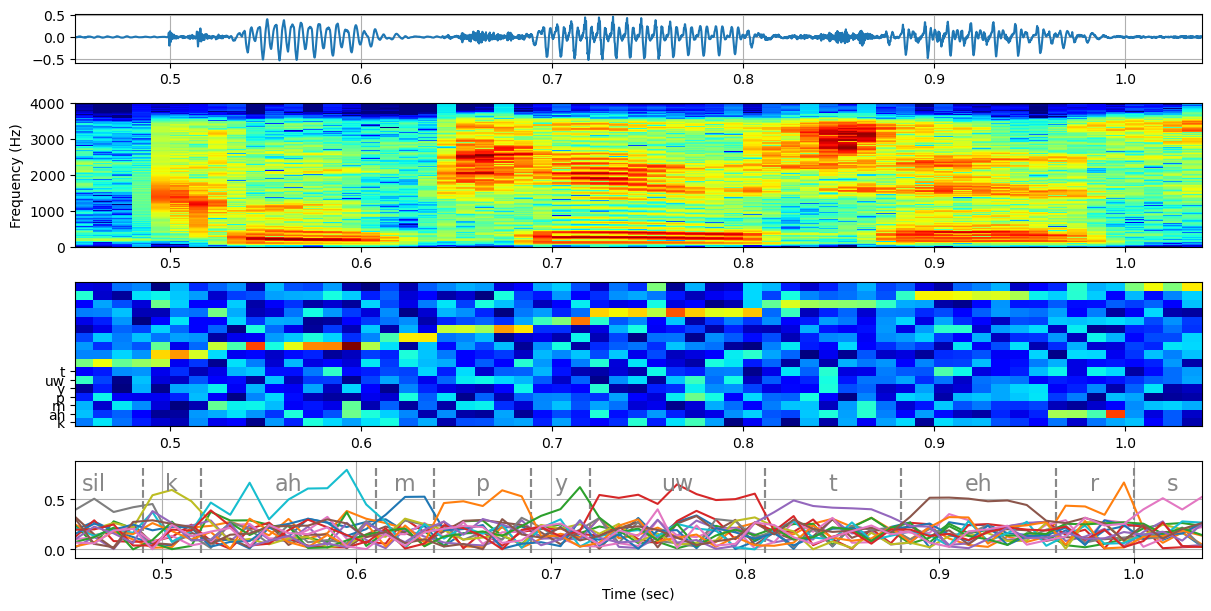

In [14]:
#df = df10[['iy','v','ih','n']]
labels = ['k','ah','m','p','y','uw','t']
frames = [45,104]
df = df10[labels]  # .iloc[frames[0]:frames[1]]
df=df1.mul(3.)
fig = spchd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgfreq,img_ftrs=[df.values.T],  line_ftrs=[df.values.T],
              frames=frames,sample_rate=sr)
# add labels to the heatmap
fig.axes[2].set_yticks(np.arange(len(labels))+0.5)
fig.axes[2].set_yticklabels(labels)
# add labels to the line features
spchd.add_seg_plot(fig,3,segphn,ypos=0.8,color='#888')
display(fig)

In [15]:
mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [16]:
mpl.use('pdf')

In [5]:
fig.show()

NameError: name 'fig' is not defined